In [12]:
# Used libraries

import csv
import re
from brian2 import *
import numpy as np
from scipy.interpolate import interp1d
import brian2.numpy_ as np
import matplotlib.pyplot as plt
import time
import warnings
from scipy import interpolate


# ML eNeuron (electronic Neuron)

Visualising the transfer function (firing rate depending on input current) and membrane potential shape (potential depending on time) of the ML eNeuron from post layout simulation results.

number of point =  10091 , a magnitude of input current of : 10.03 nA


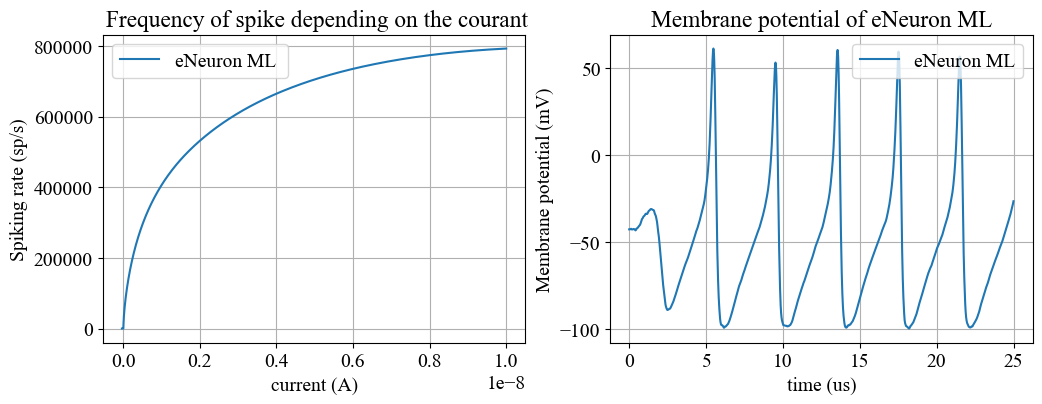

In [22]:
# Importing the .csv file of firing rate depending on the input current from PSL results
csv_file_path = 'FT_augmented.csv' #Activation function 

input_current = []
spike_rate = []

# Open the CSV file
with open(csv_file_path, 'r') as file:
    csv_reader = csv.reader(file, delimiter='\t')
    # Skip the header row
    next(csv_reader)
    for row in csv_reader:
        values = re.split(r',', row[0])
        input_current.append(float(values[0]))
        spike_rate.append(float(values[1]))
        
print("number of point = ", len(spike_rate), ", a magnitude of input current of :", (max(input_current)-min(input_current))*1e9,"nA")


csv_file_path = 'spike.csv'

time = []
v_spike = []

with open(csv_file_path, 'r') as file:
    csv_reader = csv.reader(file, delimiter='\t')
    next(csv_reader)
    for row in csv_reader:
        values = re.split(r'\s+', row[0])

        time.append(float(values[0])*1e6)
        v_spike.append(float(values[1])*1e3) 


# Plot the data
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)  
plt.plot(input_current, spike_rate, label='eNeuron ML ')
plt.xlabel('current (A)')
plt.ylabel('Spiking rate (sp/s)')
plt.title(' Frequency of spike depending on the courant')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)  
plt.plot(time[:2500], v_spike[:2500], label='eNeuron ML')
plt.xlabel('time (us)')
plt.ylabel('Membrane potential (mV)')
plt.title('Membrane potential of eNeuron ML')
plt.grid(True)
plt.legend()

plt.show()

In [23]:
def reducing_list(original_list, new_size):
    '''
        Function that reduces the size of a list and lessen the amount of computation
    In input:
        - Original_list: list you want to reduce in size
        - new_size: size desired for the list
    It returns:
        - Similar list with desired size
    '''
    original_size = len(original_list)
    if new_size >= original_size:
        return original_list  

    # Calculate the sampling interval
    interval = original_size / new_size

    # Sample elements at regular intervals
    new_list = [original_list[int(i * interval)] for i in range(new_size)]

    return new_list



x = input_current
y = spike_rate

nb_point_interpolation = 1101

funct = interpolate.interp1d(x, y)

x_reduit = reducing_list(x,nb_point_interpolation)
y_reduit = reducing_list(y,nb_point_interpolation)

x_fit = np.linspace(min(x), max(x),min(nb_point_interpolation,len(spike_rate)))
y_fit = funct(x_reduit)   



In [24]:
# Force Brian to use numpy for code generation
prefs.codegen.target = 'numpy'

# Here I reduced the size of the data to accelerate the next processus
i_new = reducing_list(input_current,nb_point_interpolation)
f_new = reducing_list(spike_rate,nb_point_interpolation)

# Convert data to use with Brian2
i_new = i_new * amp  # Now x2 is in amperes
f_new = f_new * Hz      # Now y2 is in amperes (ensure this is the correct unit!)

interp_function = interp1d(i_new, f_new, fill_value='extrapolate')

@check_units(x=amp, result = Hz)
def y_interp_function(x):
    return interp_function(x)*Hz

# Modeling the ML eNeuron with Brian2 equations

### Name: Analog Spiking Neuron Model for Unsupervised STDP-based learning in Neuromorphic Circuits

    => equations described in the paper

It employs a logarithm fit function rather than interpolation function. It allows to reduce time-computation.


### WITHOUT leaky term

In [31]:
from brian2 import clear_cache
from brian2 import device
device.reinit()
start_scope()

# Simulation parameters
defaultclock.dt = 0.01*us  

min_input_current, max_input_current = min(i_new), max(i_new)
v_rest = -80*mV
v_threshold = 60*mV  
v_reset = -100*mV
refrac = 0*us
v0 = -40*mV  
tau = 0.5*ms
tau2 = 15*us
Rm = 5000*Mohm
I0=1*amp
a_v = 1126.6343973469338
b_v = 169200.45773494235
alpha_e = 0.15
alpha_i = 0.04
beta_e = 1.9
beta_i = 0.5
x_threshold_v= 8.3e-11*amp
avoid_error = 0.01*pA #This constant exists only to make sure that there isn't in any case a log(0) which implies errors.
a_value = 6.23667974e13
k_redres = 0.007704519252680564
k_redres = -0.00930049450970849
k_redres = -0.0018141002616710589

avoid_error = 0.01*pA
c = 1




# 3-segment model
V_x, V_y, V_z= 8*mV,62*mV,90*mV
R_x = Rm*(V_x/mV)/(15/60)/(abs(v_threshold/mV)+abs(v_reset/mV))  #New resistance for rising till V_a
R_y = Rm*(V_y/mV)/(35/60)/(abs(v_threshold/mV)+abs(v_reset/mV)) #New resistance for rising till V_b
R_z = Rm*(V_z/mV)/(10/60)/(abs(v_threshold/mV)+abs(v_reset/mV)) #New resistance for rising till V_b
v_std_thresh = 3.3*mV #standart deviation for the threshold value (randn :drawn from the standard normal distribution, i.e. with mean 0 and standard deviation 1) 


# This model use a constant Resistance and a log approximation
neuron_eqs_v3 = '''
dv/dt =  (v_rest - v) / tau2 + ( int(I_total > x_threshold_v) *(I_syn*I0)/(a_value*Hz)*Rm) / tau : volt (unless refractory)
I_total = clip(Ie + I_inhi + I, 0*nA, 15*nA) : amp
I_syn = Hz*(a_v + b_v * log((1-int(I_total > x_threshold_v))+int(I_total > x_threshold_v)*(I_total+avoid_error)/(x_threshold_v) )) : Hz (constant over dt)
Ie =  alpha_e*ge * uS *(80*mV -v)           : amp
I_inhi =  alpha_i*gi * uS *(-120*mV -v)           : amp
I : amp
dge/dt = -ge/(beta_e*us)            : 1
dgi/dt = -gi/(beta_i*us)            : 1
Rm = (R_x)*int(v<=(v_reset+V_x)) + (R_y)*int(v<=(v_reset+V_x+V_y))*(1-int(v<(v_reset+V_x))) + (R_z)*int(v>(v_reset+V_x+V_y)) : ohm

threshold = v_threshold + int(noise_activity)*v_std_thresh*randn() : volt (constant over dt)
noise_activity : boolean (shared) # (un)Activate the noise
'''

n = 1

input_group_v3 = NeuronGroup(n, neuron_eqs_v3, threshold='v >= v_threshold', reset='v = v_reset', refractory=0*us, method='heun')
input_group_v3.I = ' 0.365*nA '
input_group_v3.v = -100*mV



duration = 0.02160 * ms
# Monitor setup
monitor3 = SpikeMonitor(input_group_v3)

run(duration, report='text', report_period = 60*second)

firing_rates3 = monitor3.count / duration
print(" firing_rates3 = ", firing_rates3)

trace3 = StateMonitor(input_group_v3, 'v', record=[0])
input_group_v3.v = -100*mV
run(0.023 * ms, report='text', report_period = 60*second)

Starting simulation at t=0. s for a duration of 21.6 us
21.6 us (100%) simulated in < 1s
 firing_rates3 =  [231.48148148] kHz
Starting simulation at t=21.6 us for a duration of 23. us
23. us (100%) simulated in < 1s


### Calculates the representation error of each model 

We calculate and compare the surface of the rise of the membrane potential reaching the threshold value.
The models used do not have a refractory time, therefore the averaged slope have to be smaller than the eNeuron ML.

 integr eNeuron ML =  156.24744088895542
 integr model v3 =  176.7894245339494


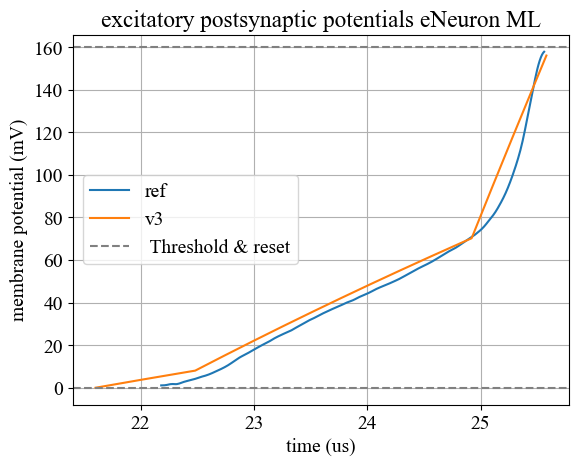

In [32]:
nb=400
data1 = v_spike[2200:2200+nb]
data4 = trace3[0].v[:nb]/mV

plt.figure()
potent = np.copy(v_spike[2200:2200+nb])
potent += abs(v_reset/mV)
min_pot,max_pot = np.argmin(potent),np.argmax(potent)
potent = potent[min_pot:max_pot]
time_t = np.copy(time[2200:2200+nb])
time_t = time_t[min_pot:max_pot]


timestep = [time_t[i+1] - time_t[i] for i in range(len(time_t)-1)]

integr_ref = sum(potent)*np.mean(timestep)
print(" integr eNeuron ML = ", integr_ref)
plt.plot(time_t,potent,label='ref')


potent = np.copy(trace3[0].v[:nb]/mV)
potent += abs(v_reset/mV)
min_pot,max_pot = np.argmin(potent),np.argmax(potent)
potent = potent[min_pot:max_pot]
time_t = np.copy(trace3.t/us)
time_t = np.copy(time_t[min_pot:max_pot])

timestep = [time_t[i+1] - time_t[i] for i in range(len(time_t)-1)]

integr_3 = sum(potent)*np.mean(timestep)
print(" integr model v3 = ", integr_3)
plt.plot(time_t,potent,label='v3')

plt.axhline(y=100+v_threshold/mV, color='grey', linestyle='--',label=' Threshold & reset')
plt.axhline(y=0, color='grey', linestyle='--')
plt.xlabel('time (us)')
plt.ylabel('membrane potential (mV)')
plt.title('excitatory postsynaptic potentials eNeuron ML')
plt.grid(True)
plt.legend()
plt.show()




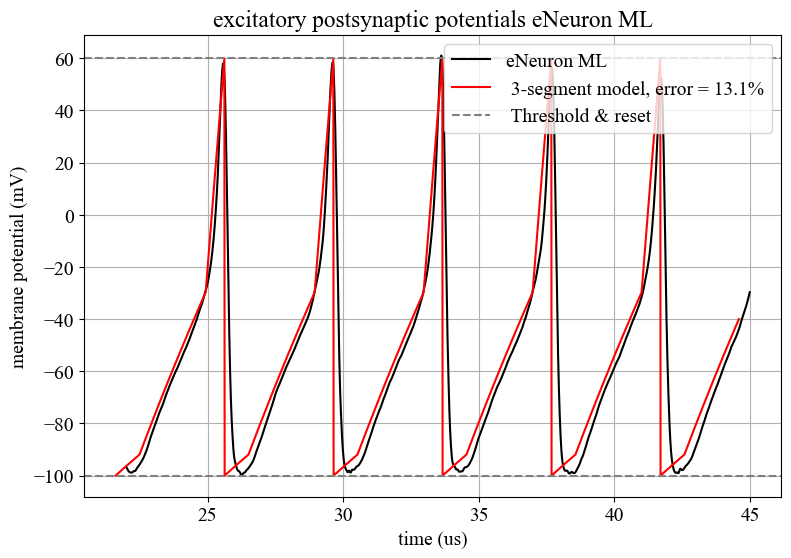

In [33]:

plt.figure(figsize=(9, 6))
plt.plot(time[2200:4500], v_spike[2200:4500],color='black', label='eNeuron ML')
plt.plot(trace3.t/us, trace3[0].v/mV,color='r',label=f' 3-segment model, error = {round(100*abs((integr_3-integr_ref)/integr_ref),1)}%')


plt.axhline(y=v_threshold/mV, color='grey', linestyle='--',label=' Threshold & reset')
plt.axhline(y=v_reset/mV, color='grey', linestyle='--')
plt.xlabel('time (us)')
plt.ylabel('membrane potential (mV)')
plt.title('excitatory postsynaptic potentials eNeuron ML')
plt.grid(True)
plt.legend()
#plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
#plt.subplots_adjust(right=0.75)


plt.show()

# Modeling eNeuron ML WITH leaky term

Focused on the 3-segment model used in the paper


In [34]:
from brian2 import clear_cache
from brian2 import device
device.reinit()
start_scope()


# Simulation parameters
duration = 0.5*ms #short time for a biological neuron but enough for eNeuron Cadence
defaultclock.dt = 0.001*us  
#defaultclock.dt = 0.01*us  


n = nb_point_interpolation

input_group_v3 = NeuronGroup(n, neuron_eqs_v3, threshold='v >= v_threshold', reset='v = v_reset', refractory=0*us, method='heun')
input_group_v3.I = i_new #'15*nA * i / (n-1)'
input_group_v3.noise_activity = True


# Monitor setup
#monitor1 = SpikeMonitor(input_group_v1)
#monitor2 = SpikeMonitor(input_group_v2)
monitor3 = SpikeMonitor(input_group_v3)

run(duration, report='text', report_period = 600*second)

#firing_rates1 = monitor1.count / duration
#firing_rates2 = monitor2.count / duration
firing_rates3 = monitor3.count / duration


Starting simulation at t=0. s for a duration of 0.5 ms
0.5 ms (100%) simulated in 4m 47s


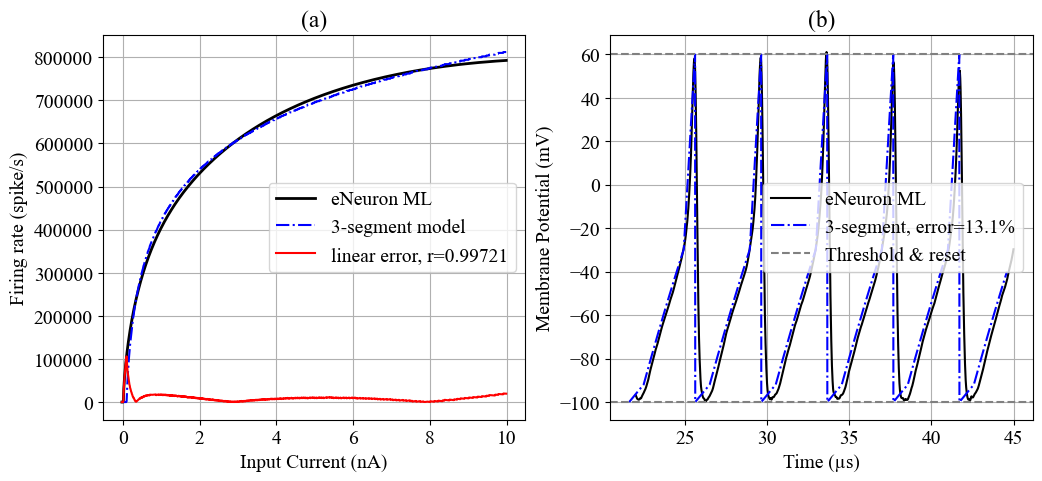

In [35]:

from matplotlib import rcParams

rcParams['font.family'] = 'Times New Roman'
rcParams['font.size'] = 14

plt.figure(figsize=(12, 5))

# Plotting firing rate as a function of input current
plt.subplot(1, 2, 1) 
plt.plot(i_new/nA, f_new/Hz, color='black',linewidth=2, label="eNeuron ML")
plt.plot(input_group_v3.I/nA, firing_rates3, color='b',linestyle='-.', linewidth=1.5, label="3-segment model")
plt.plot(input_group_v3.I/nA, [abs(i-j)**1 for i, j in zip(f_new/Hz, firing_rates3*second)], color='red', label=f"linear error, r={round(np.corrcoef(f_new, firing_rates3)[0, 1], 5)}")
plt.xlabel('Input Current (nA)')
plt.ylabel('Firing rate (spike/s)')
#plt.title('(a)  eNeuron ML and Brian2 neuron model')
plt.title('(a)')
plt.grid(True)
plt.legend(loc='center right')

plt.subplot(1, 2, 2) 
plt.plot(time[2200:4500], v_spike[2200:4500], color='black', label='eNeuron ML')
plt.plot(trace3.t/us, trace3[0].v/mV, color='b', linestyle='-.', label=f'3-segment, error={round(100*abs((integr_3-integr_ref)/integr_ref), 1)}%')
plt.axhline(y=v_threshold/mV, color='grey', linestyle='--', label='Threshold & reset')
plt.axhline(y=v_reset/mV, color='grey', linestyle='--')
plt.xlabel('Time (µs)')
plt.ylabel('Membrane Potential (mV)')
#plt.title('(b)  excitatory postsynaptic potentials eNeuron ML')
plt.title('(b)')
plt.grid(True)

#lgd = plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
#lgd = plt.legend()
lgd = plt.legend(loc='center right')

plt.show()


### Zoom on the very left part

max Firing rate eNeuron ML = 792559.6043922332 max Firing rate model (v3)= 812000.0 

k_redres =  -0.023941373901190666


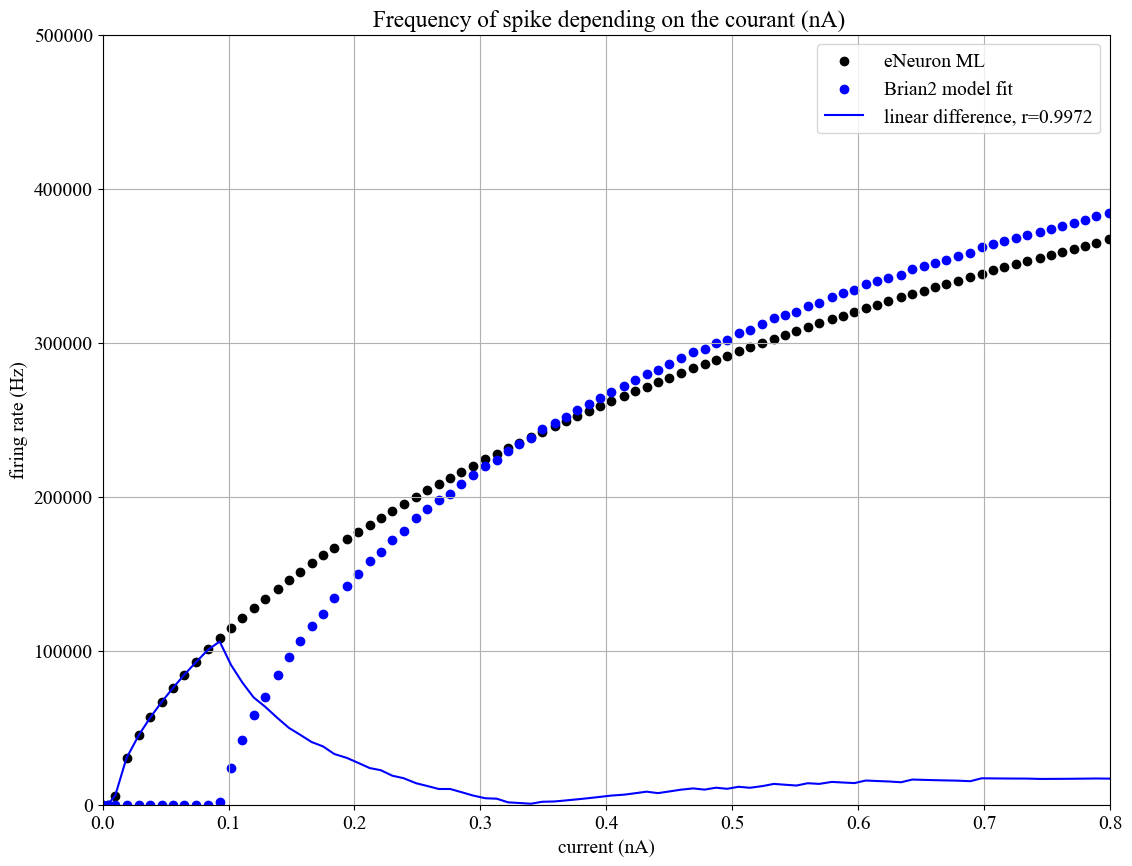

In [36]:
print("max Firing rate eNeuron ML =", f_new[-1]/Hz, "max Firing rate model (v3)=",firing_rates3[-1]*second,"\n")
k_redres =  (f_new[-1]/Hz)/(firing_rates3[-1]*second) - 1
print("k_redres = ",k_redres)

plt.figure(figsize=(13, 10))

plt.scatter(i_new/nA,f_new/Hz,color='black',label=" eNeuron ML")
plt.scatter(input_group_v3.I/nA, firing_rates3,color='b',label=" Brian2 model fit")
plt.plot(input_group_v3.I/nA,[abs(i-j) for i,j in zip(f_new/Hz,firing_rates3*second)],color='b',label=f" linear difference, r={round(np.corrcoef(f_new, firing_rates3)[0, 1],4)}")

plt.xlabel('current (nA)')
plt.ylabel('firing rate (Hz)')
plt.title(' Frequency of spike depending on the courant (nA)')
plt.grid(True)
plt.legend()
plt.xlim([-5e-12,0.8])  
plt.ylim([-1, 500000])

plt.show()